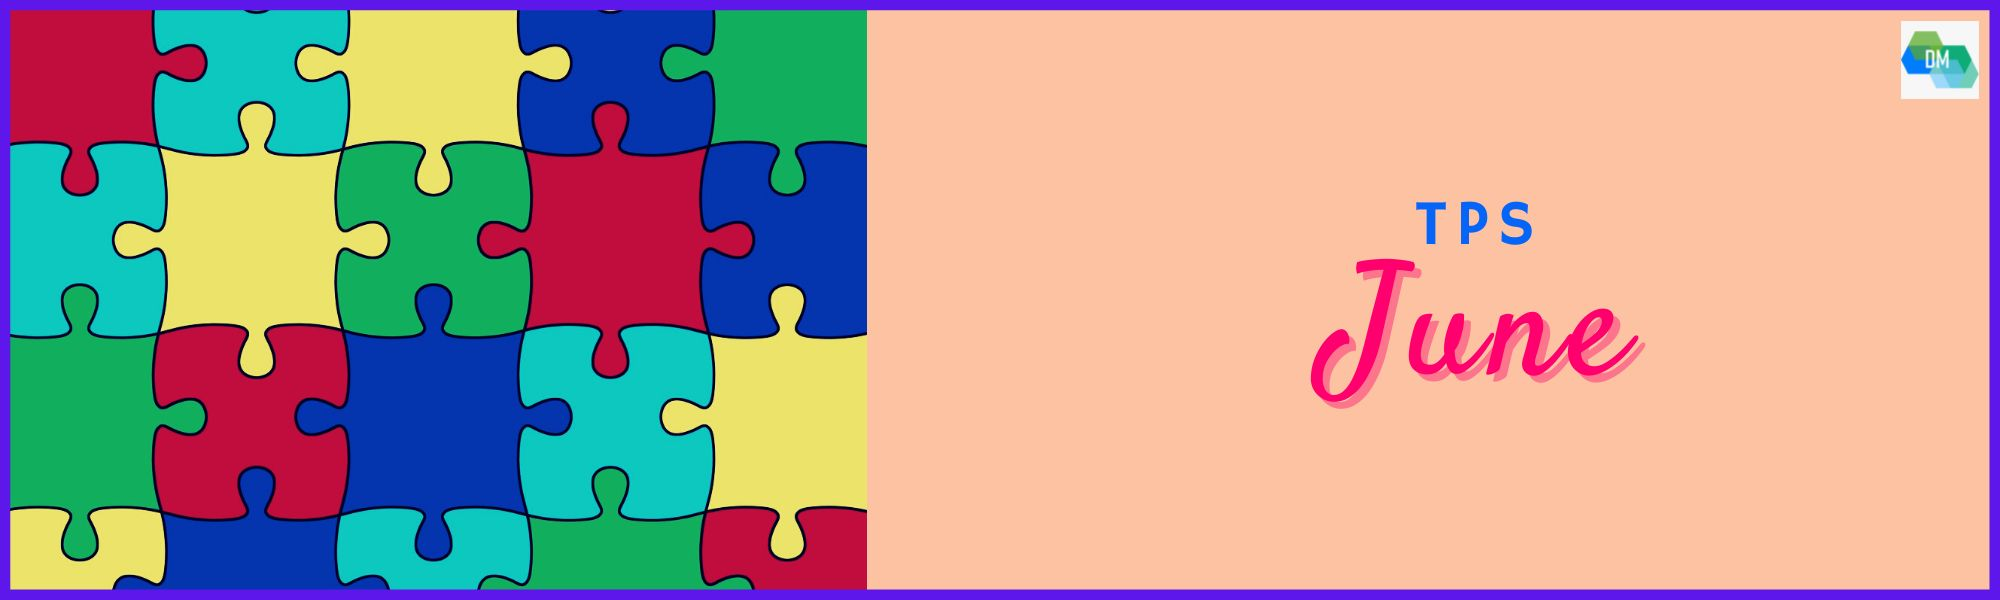

<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">For this challenge, you are given (simulated) manufacturing control data that contains missing values due to electronic errors. Your task is to predict the values of all missing data in this dataset.</p>

**Observations on this TPS dataset:**
- The dataset has `10,00,000` rows and `80` columns 
- The dataset contains`4` features categories - `F_1`,`F_2`,`F_3` and `F_4`
- `F_1` and `F_4` are divided into `15` features while `F_2` and `F_3` are divided into `25` features.
- `25` features are `int` type and `55` features are `float` type
- We have to fill the missing values. But not all the columns have missing values.

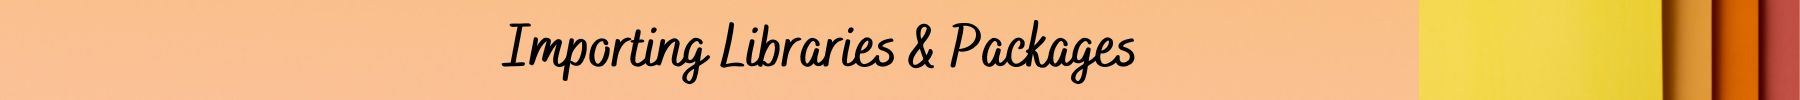

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

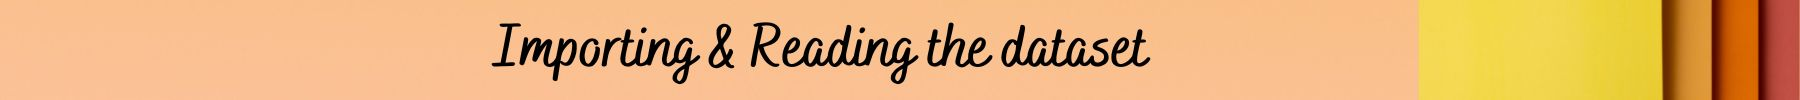

In [ ]:
df_data = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv', index_col='row_id')
df_subm =  pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col='row-col')

In [ ]:
df_data_row_count, df_data_column_count = df_data.shape
print('Total number of rows:', df_data_row_count) 
print('Total number of columns:', df_data_column_count)

In [ ]:
df_data.head()

In [ ]:
df_data.describe().T

In [ ]:
df_data.info()

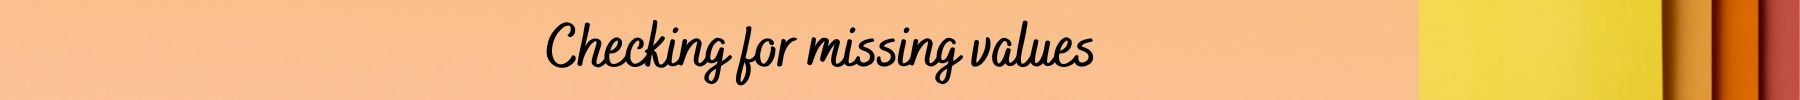

In [ ]:
df_data.isna().sum()

In [ ]:
background_color = 'white'
missing = pd.DataFrame(columns=['% Missing values'],data=df_data.isnull().sum()/len(df_data))
fig = plt.figure(figsize=(10, 30),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar=False,annot=True,fmt=".2%", linewidths=2,cmap="prism",vmax=1, ax=ax0)
plt.show()

In [ ]:
features = list(df_data.columns)
features = features[1:len(features)]
F1_features = [feat for feat in features if feat[:3] == "F_1"]
F2_features = [feat for feat in features if feat[:3] == "F_2"]
F3_features = [feat for feat in features if feat[:3] == "F_3"]
F4_features = [feat for feat in features if feat[:3] == "F_4"]

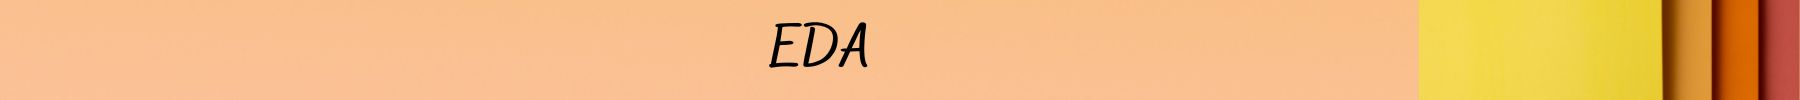

## Features F_1 

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F1_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

## Features F_2

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F2_features):
    plt.subplot(5, 5, i+1)
    axs = sns.countplot(x = df_data[f],palette="YlOrRd_r")
plt.tight_layout()
plt.show()

## Features F_3

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F3_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

## Features F_4

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F4_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df_data[f],color="#d90429")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(11,11))
corr=df_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, robust=True, center=0,square=True, linewidths=.6,cmap='YlOrRd_r')
plt.title('Correlation')
plt.show()

In [ ]:
gc.collect()

In [ ]:
df_data1 = df_data.copy()

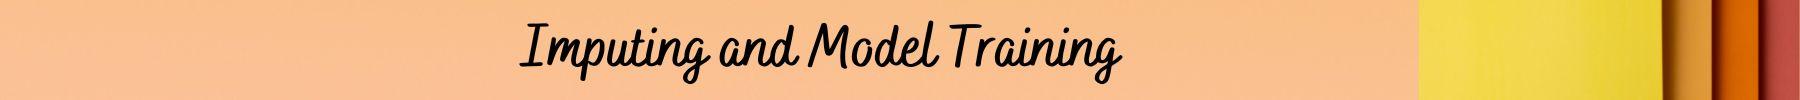

In [ ]:
F4_feat = [col for col in df_data1.columns if col.split('_')[1] == '4']
df_new = pd.DataFrame()
for feature in df_data1.columns:
    if feature in F4_feat:
        df_new[feature] = df_data1[feature]
F123_features = df_data1.drop(F4_feat, axis=1)

In [ ]:
feat_imp = SimpleImputer(missing_values=np.nan, strategy= 'mean')
imp = pd.DataFrame(feat_imp.fit_transform(F123_features), columns = F123_features.columns)

In [ ]:
for column in df_new.columns:
    df_train = df_new[df_new[column].isna() == False]
    df_test = df_new[df_new[column].isna() == True]
    
    X = df_train.drop(column, axis=1)
    y = df_train[column]
    
    model = XGBRegressor(random_state=123, n_estimators= 3000, booster='gbtree',verbosity = 2,tree_method = 'gpu_hist')
    model.fit(X, y)
    
    pred = model.score(X, y)
    df_new[column][df_test.index] = model.predict(df_test.drop(column, axis = 1))

In [ ]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values,max_display = 20)

In [ ]:
df = pd.concat([imp, df_new], axis = 1)

In [ ]:
for i in tqdm(df_subm.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    df_subm.loc[i, 'value'] = df.loc[row, col]
df_subm.to_csv('submission_xgb.csv')
df_subm

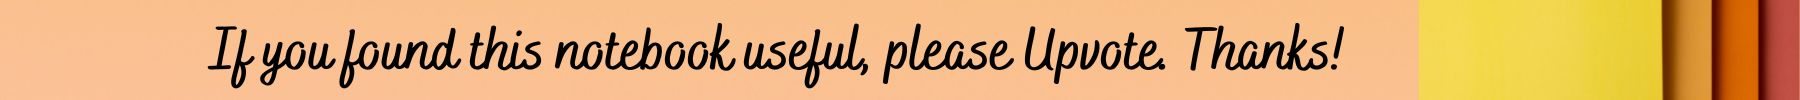